Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.filters import gaussian, threshold_otsu, threshold_multiotsu
from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects, binary_dilation, disk
import czifile
import skimage.io as io
from skimage import exposure
from cellpose import models
from skimage.filters import unsharp_mask
from skimage.segmentation import find_boundaries
import cv2

model = models.Cellpose(model_type='cyto3')
# model = models.Cellpose(model_type='nuclei')

c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\cellpose\resnet_torch.py:275: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename, 

In [2]:
MIN_INCLUSION_SIZE = 10
MAX_INCLUSION_SIZE = 10000
COLOR_SCHEME = 'gray'
RADIUS = 15

Define Sub Functions

In [3]:
def show_image(image,cmap=COLOR_SCHEME):
    plt.imshow(image, cmap=cmap)
    plt.show()

def preprocess_green_channel(green_channel):
    """Preprocess the green channel for cell segmentation and inclusion quantification."""
    confocal_img = gaussian(green_channel, sigma=2)
    # increase image contrast
    
    # confocal_img = exposure.adjust_sigmoid(green_channel, cutoff=0.25)
    confocal_img = (confocal_img - confocal_img.min()) / (confocal_img.max() - confocal_img.min())
    
    return confocal_img

def preprocess_dapi_channel(dapi_channel):
    """Preprocess the DAPI channel for nuclei quantification."""
    blurred_dapi = gaussian(dapi_channel, sigma=2)
    threshold_value = threshold_otsu(blurred_dapi)
    binary_image = blurred_dapi > threshold_value
    # show_image(binary_image)
    cleaned_image = remove_small_objects(binary_image, min_size=400)
    merged_image = binary_dilation(cleaned_image, footprint=disk(5))
    labeled_image = label(merged_image)
    return labeled_image

def count_nuclei(labeled_image):
    """Count the number of nuclei in the labeled image."""
    return len(np.unique(labeled_image)) - 1


def increase_contrast(image):
    """Increase the contrast of the image."""
    p2, p98 = np.percentile(image, (2, 98))
    return exposure.rescale_intensity(image, in_range=(p2, p98))

def segment_cells(green_channel):
    """Segment cells in the green channel."""
    # normalize
    green_channel = (green_channel - np.min(green_channel)) / ((np.max(green_channel) - np.min(green_channel)))
    mean_intensity = np.mean(green_channel[green_channel > 0.2])
    # print("Mean Intensity: ", mean_intensity)
    green_channel_remove_inclusions = np.where(green_channel < 0.6, green_channel, mean_intensity) # dim down inclusions
    green_channel_remove_inclusions = gaussian(green_channel_remove_inclusions, sigma=5) # blur

    
    # normalize
    green_channel_remove_inclusions = (green_channel_remove_inclusions - np.min(green_channel_remove_inclusions)) / ((np.max(green_channel_remove_inclusions) - np.min(green_channel_remove_inclusions)))
    show_image(green_channel_remove_inclusions)

    # Detect cells in the green channel
    # keep increasing diameter until cells are detected
    diameter = 150

    while diameter < 700:

        masks, flows, styles, diams = model.eval(green_channel_remove_inclusions, diameter=diameter, channels=[0, 0])
        labeled_cells = label(masks)
        # if there are more than 0 cells
        if np.max(labeled_cells) > 0:
            return labeled_cells
        diameter += 25
    # no cells found, throw an error
    return None

def extract_inclusions(green_channel,mask,display_graph=False):
    applied_mask_blurred = gaussian(green_channel, sigma=1) * mask
    applied_mask_eliminate_background = applied_mask_blurred[applied_mask_blurred > 0] # filter out 0
    
    # normalize 
    applied_mask_eliminate_background = (applied_mask_eliminate_background - np.min(applied_mask_eliminate_background)) / ((np.max(applied_mask_eliminate_background) - np.min(applied_mask_eliminate_background)))

    # calculate statistics
    mean_intensity = np.mean(applied_mask_eliminate_background)
    median_intensity = np.median(applied_mask_eliminate_background)
    q1 = np.percentile(applied_mask_eliminate_background, 25)
    q3 = np.percentile(applied_mask_eliminate_background, 75)
    
    hist, bin_edges = np.histogram(applied_mask_eliminate_background, bins='fd')
    
    applied_mask = green_channel * mask
    # 0.5 is an empirical value that seems to work well
    if q3 < 0.5 and len(bin_edges) > 20:
        # the population is skewed to the left, indicating that there are inclusions
        threshold = max(threshold_otsu(applied_mask),0.5) # use otsu thresholding to find the threshold
    elif q3 >= 0.7:
        # definitely no inclusions
        threshold = 1
    else:
        # probably no inclusions, but not sure, so we set a very high threshold in case there are inclusions
        threshold = 0.999
    
    inclusions = applied_mask > threshold # apply the threshold

    inclusions = remove_small_objects(inclusions, min_size=MIN_INCLUSION_SIZE) # remove small objects
    inclusions = inclusions ^ remove_small_objects(inclusions, min_size=MAX_INCLUSION_SIZE) # remove large objects

    if display_graph:
        
        print("Threshold: ", threshold)
        print("Bin count", len(bin_edges))

        plt.hist(applied_mask_eliminate_background, bins='fd')  
        plt.axvline(mean_intensity, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_intensity:.2f}')
        plt.axvline(median_intensity, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_intensity:.2f}')
        plt.axvline(q1, color='blue', linestyle='dashed', linewidth=2, label=f'Q1: {q1:.2f}')
        plt.axvline(q3, color='purple', linestyle='dashed', linewidth=2, label=f'Q3: {q3:.2f}')
        plt.legend()
        plt.title("Intensity histogram")
        plt.show()

    return inclusions



def remove_overlapping_lipids(red_channel_thresholded,inclusion_image):
    # remove the lipids that overlap with the inclusions
    # use regionprops to separate the lipids
    # make result the same size as red_channel_thresholded
    result = np.zeros_like(red_channel_thresholded)
    labeled_red_channel = label(red_channel_thresholded)
    for i, lipid in enumerate(regionprops(labeled_red_channel)):
        lipid_image = red_channel_thresholded * (labeled_red_channel == lipid.label)
        overlap = lipid_image * inclusion_image
        if np.sum(overlap) > 0:
            continue
        result[lipid.coords[:, 0], lipid.coords[:, 1]] = 1
    return result

def generate_inclusion_image(green_channel, labeled_cells):
    inclusion_image = np.zeros_like(green_channel)

    for i, cell in enumerate(regionprops(labeled_cells)):
        if cell.area < 100:
            continue
        
        mask = labeled_cells == cell.label
        
        inclusions = extract_inclusions(green_channel, mask)

        inclusion_image += inclusions
    # show_image(inclusion_image)
    return inclusion_image

def resize_image(image, target_size):
    
    return cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)


In [4]:
def analyze_image(cell_image_path, basename,verbose=False):
    """
    Analyze an image by its individual cells
    Args:
        image_path: Path to the .czi image file.
        basename: Base name for the file, used in the output DataFrame.

    Returns:
        A DataFrame containing details about each image 
        A second DataFrame containing details about each detected cell
    """
    
    # Load the image and squeeze dimensions
    cell_image = czifile.imread(cell_image_path)
    cell_image_squeezed = np.squeeze(cell_image)
    mitochondria_image_path = cell_image_path[:-6] + 'TMRM_zstack_' + cell_image_path[-6:]
    mitochondria_image = czifile.imread(mitochondria_image_path)
    mitochondria_image_squeezed = np.squeeze(mitochondria_image)
    green_channel = cell_image_squeezed
    # normalize the green channel
    green_channel = (green_channel - np.min(green_channel)) / ((np.max(green_channel) - np.min(green_channel)))
    # segment cells
    labeled_cells = segment_cells(green_channel)
    if labeled_cells is None:
        print(f"No cells found in {cell_image_path}. Skipping.")
        return None
    print("Green Channel")
    show_image(green_channel)
    print("Labeled Cells")
    show_image(labeled_cells)

    # extract inclusions
    inclusion_image = generate_inclusion_image(green_channel, labeled_cells)
    print("Inclusion Image")
    show_image(inclusion_image)
    

    inclusion_counts = []
    means_whole = []
    means_inclusions = []
    means_without_inclusions = []
    # iterate through cells
    for i,cell in enumerate(regionprops(labeled_cells)):
        if cell.area < 100:
            continue

        mask = labeled_cells == cell.label
        inclusions_in_cell = inclusion_image * mask
        show_image(inclusions_in_cell)
        inclusion_count = len(regionprops(label(inclusions_in_cell)))
        inclusion_counts.append(inclusion_count)

        

        mean_intensities_whole = []
        mean_intensities_inclusions = []
        mean_intensities_without_inclusions = []
        for j in range(mitochondria_image_squeezed.shape[0]):
            channel = mitochondria_image_squeezed[j]

            channel = np.resize(channel, green_channel.shape)
            resized_channel = resize_image(channel, mask.shape)

            channel_applied_mask = resized_channel[mask > 0]
            if len(channel_applied_mask) > 0:
                mean_intensity = np.mean(channel_applied_mask)
                mean_intensities_whole.append(mean_intensity)

            channel_inclusions_only = resized_channel[inclusions_in_cell > 0]
            if len(channel_inclusions_only) > 0:
                mean_intensity_inclusions = np.mean(channel_inclusions_only)
                mean_intensities_inclusions.append(mean_intensity_inclusions)
            
            channel_without_inclusions = resized_channel[(mask > 0) & (inclusions_in_cell == 0)]
            if len(channel_without_inclusions) > 0:
                mean_intensity_without_inclusions = np.mean(channel_without_inclusions)
                mean_intensities_without_inclusions.append(mean_intensity_without_inclusions)
        
        mean_whole = np.mean(mean_intensities_whole)
        means_whole.append(mean_whole)
        mean_inclusion = np.mean(mean_intensities_inclusions)
        means_inclusions.append(mean_inclusion)
        mean_without_inclusion = np.mean(mean_intensities_without_inclusions)
        means_without_inclusions.append(mean_without_inclusion)
    
    df = pd.DataFrame({
        'Image': [basename] * len(inclusion_counts),
        'Cell': range(0, len(inclusion_counts)),
        'Inclusion Count': inclusion_counts,
        'Mean Whole Cell': means_whole,
        'Mean Inclusions': means_inclusions,
        'Mean Without Inclusions': means_without_inclusions
    })

    return df




            



    


    
    


    

In [5]:
def analyze_all_images(image_folder, images=None,verbose=False):
    if verbose:
        print("Analyzing images in folder: ", image_folder)
    # images is the list of images to analyze, if set to None, analyze all images
    all_data_1 = []
    for image in os.listdir(image_folder):
        
        if image.lower().endswith(".czi"):  # Filter for CZI files
            if images is not None and image not in images:
                continue

            # mitochondria distance\010725_mito_OA\3K_no_OA_settings\3K_Lipidtox_01.czi
            image_path = os.path.join(image_folder, image)
            
            
            
            image_base_name = os.path.basename(image)[:-4]

            if 'TMRM' in image_base_name:
                continue
            # if 'noOA' not in image_base_name:
            #     continue
            df1 = analyze_image(image_path, image_base_name,verbose=verbose)
            
            if(df1 is not None):
                all_data_1.append(df1)
            
            if verbose:
                print(image_path)
                print("-" * 200)
    if len(all_data_1) == 0:
        return
    combined_df_1 = pd.concat(all_data_1, ignore_index=True)

    combined_df_1.to_excel(f"{image_folder}_analysis_by_image.xlsx", index=False)

def analyze_subfolders(folder,verbose=False):
    for subfolder in os.listdir(folder):
        if os.path.isdir(os.path.join(folder, subfolder)):
            analyze_all_images(os.path.join(folder, subfolder),verbose=verbose)


def analyze_main_folder(folder,verbose=False):
    for subfolder in os.listdir(folder):
        if os.path.isdir(os.path.join(folder, subfolder)):
            analyze_subfolders(os.path.join(folder, subfolder),verbose=verbose)


Analyzing images in folder:  12125_TMRM_YFP/1K_WT_newnewsettings


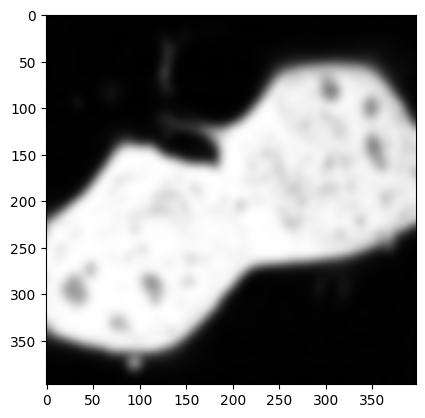

Green Channel


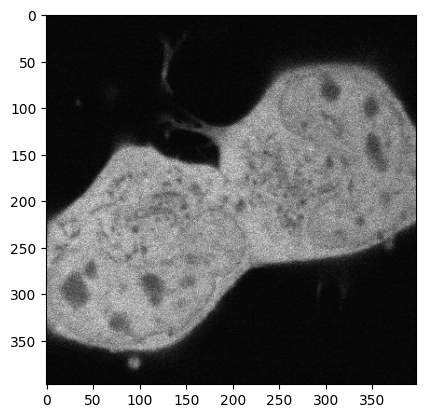

Labeled Cells


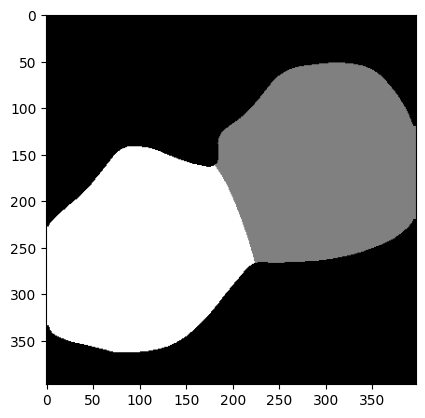

Inclusion Image


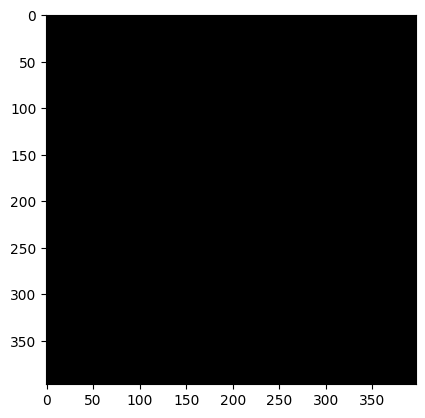

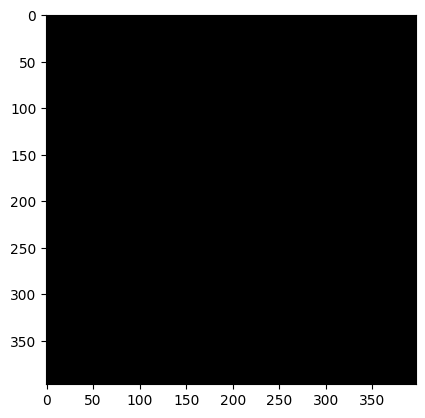

c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


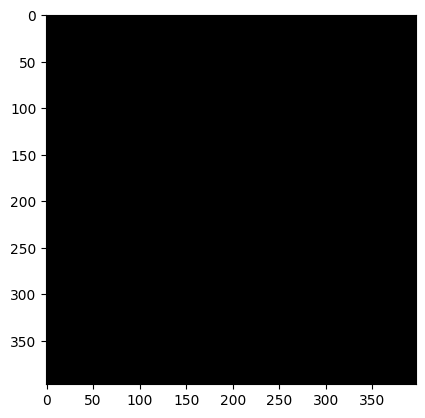

12125_TMRM_YFP/1K_WT_newnewsettings\1K_dox_noOA_01.czi
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


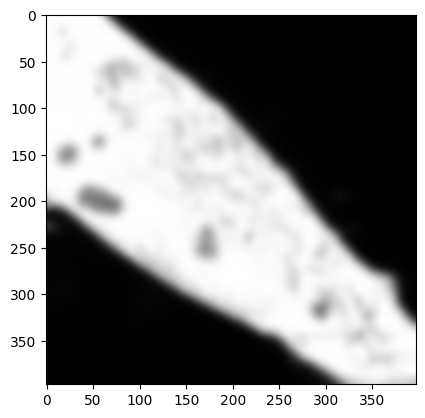

No cells found in 12125_TMRM_YFP/1K_WT_newnewsettings\1K_dox_noOA_02.czi. Skipping.
12125_TMRM_YFP/1K_WT_newnewsettings\1K_dox_noOA_02.czi
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


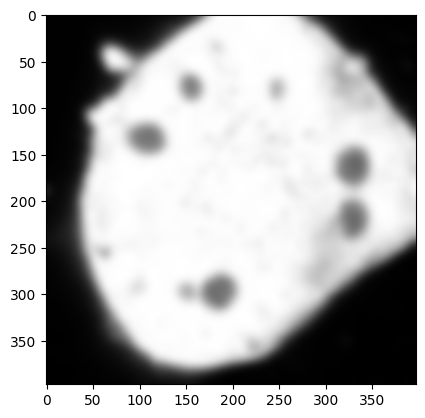

No cells found in 12125_TMRM_YFP/1K_WT_newnewsettings\1K_dox_noOA_03.czi. Skipping.
12125_TMRM_YFP/1K_WT_newnewsettings\1K_dox_noOA_03.czi
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


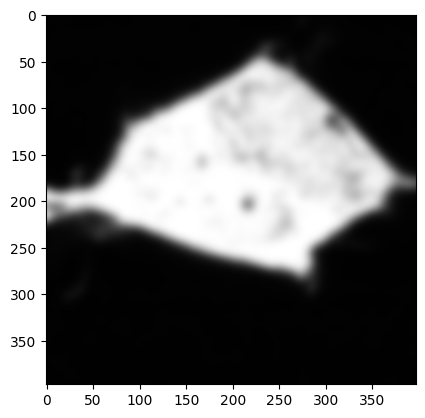

Green Channel


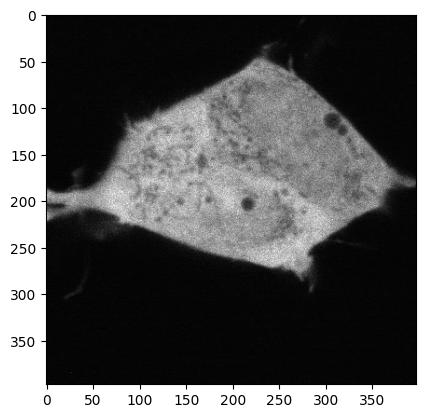

Labeled Cells


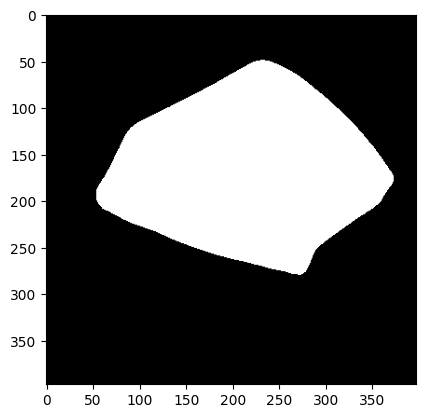

Inclusion Image


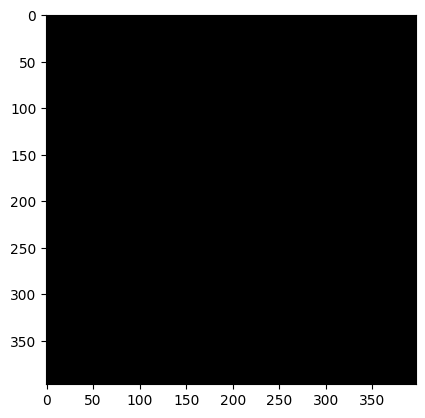

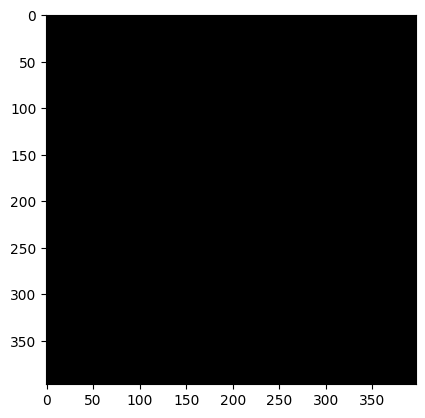

12125_TMRM_YFP/1K_WT_newnewsettings\1K_dox_noOA_04.czi
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


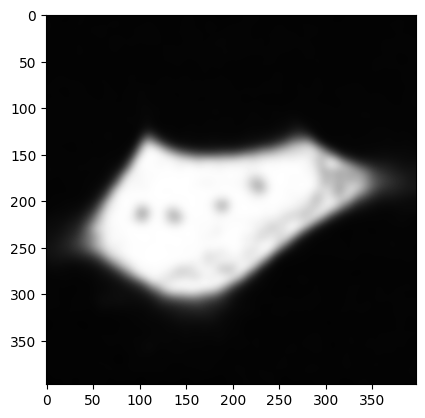

Green Channel


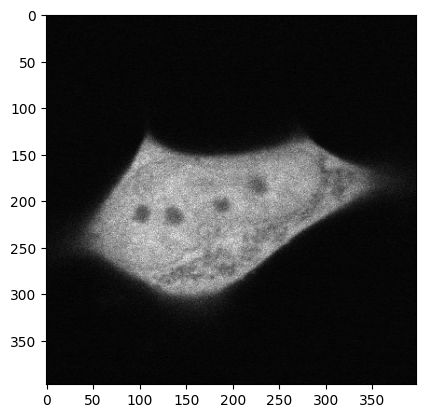

Labeled Cells


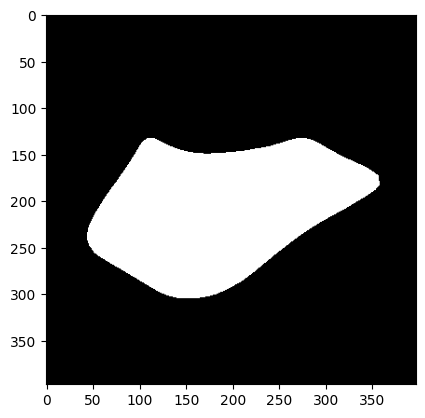

Inclusion Image


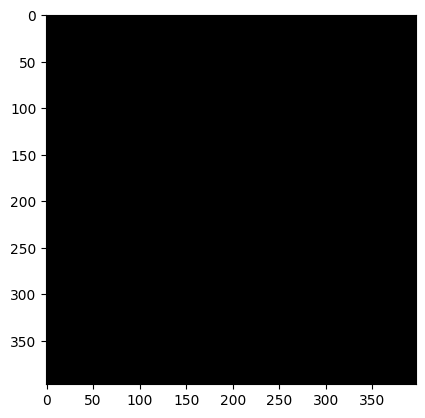

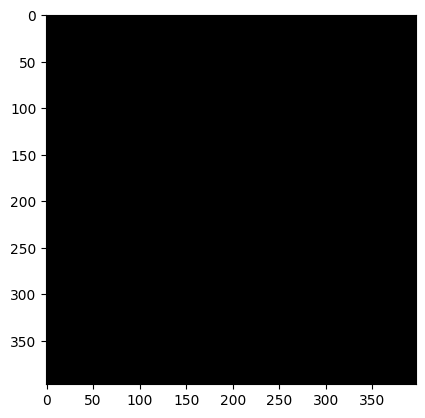

12125_TMRM_YFP/1K_WT_newnewsettings\1K_dox_noOA_05.czi
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


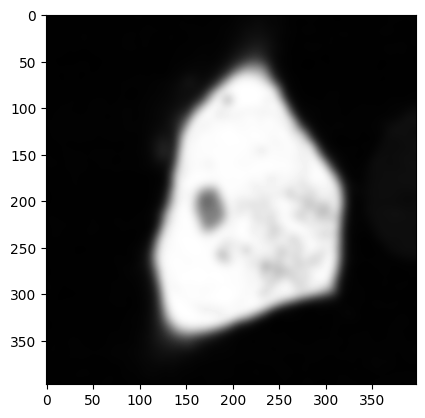

Green Channel


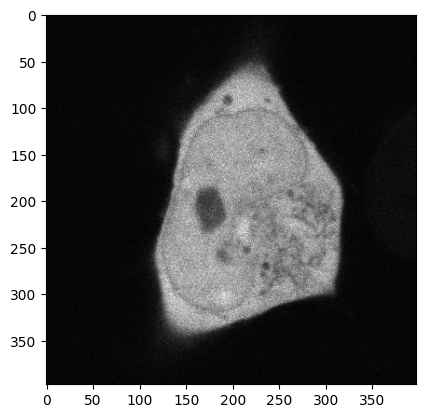

Labeled Cells


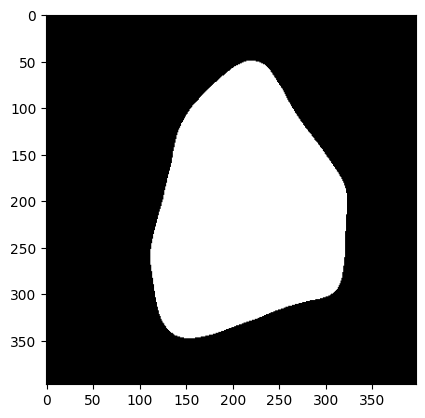

Inclusion Image


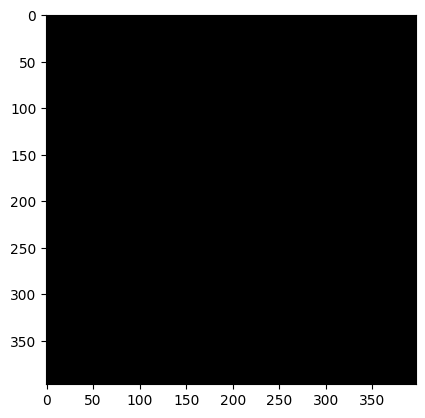

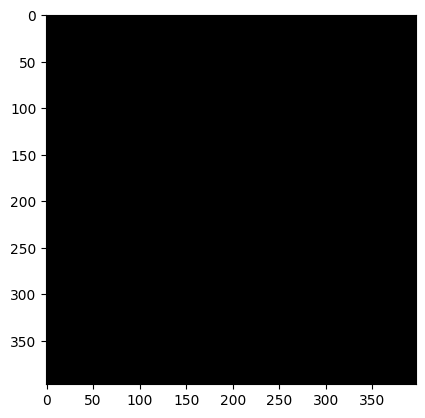

12125_TMRM_YFP/1K_WT_newnewsettings\1K_dox_noOA_06.czi
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


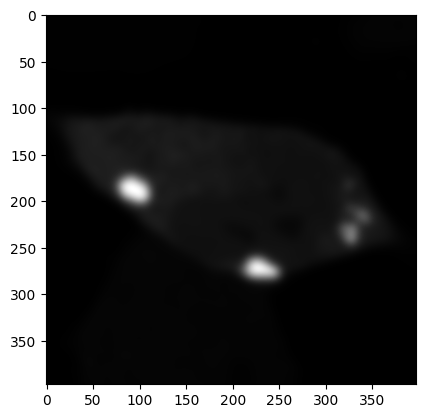

Green Channel


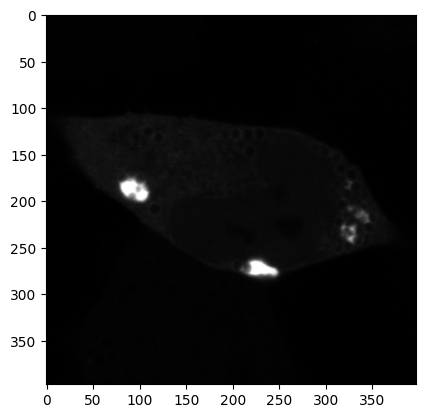

Labeled Cells


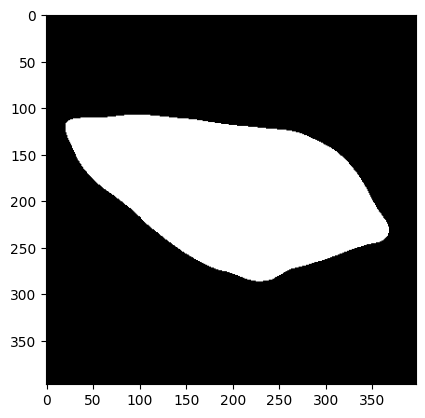

Inclusion Image


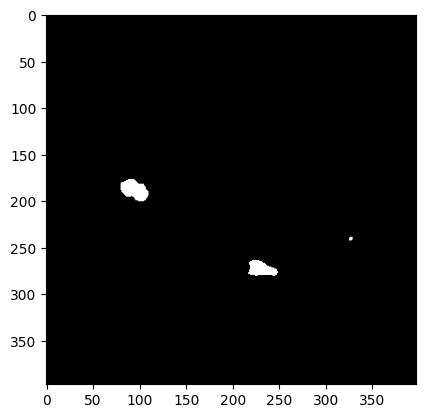

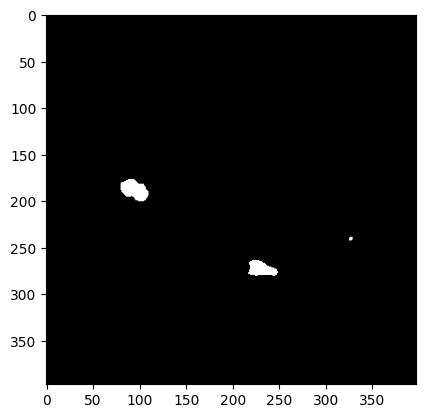

12125_TMRM_YFP/1K_WT_newnewsettings\1K_dox_OA_01.czi
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


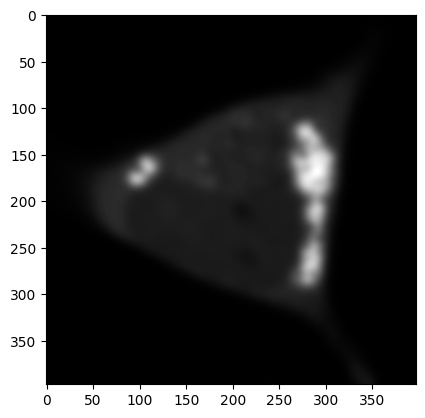

Green Channel


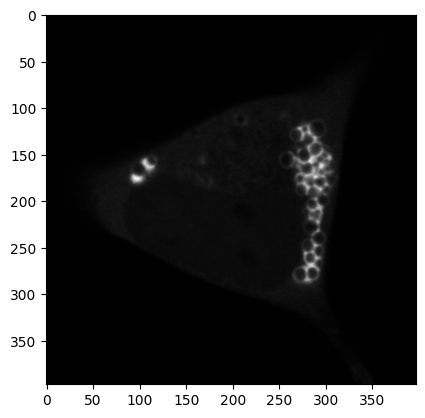

Labeled Cells


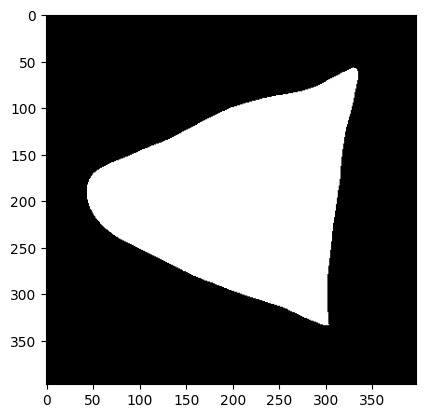

Inclusion Image


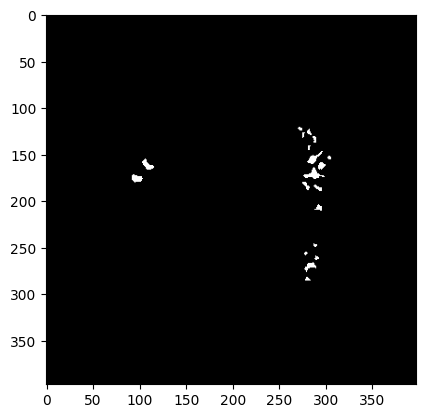

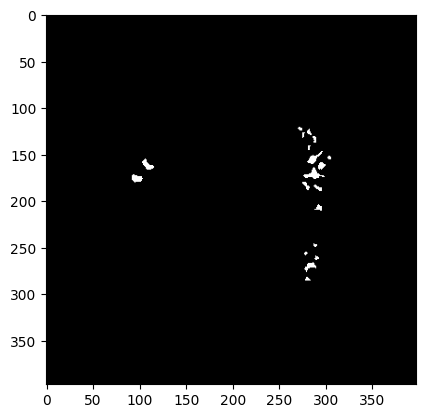

12125_TMRM_YFP/1K_WT_newnewsettings\1K_dox_OA_02.czi
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


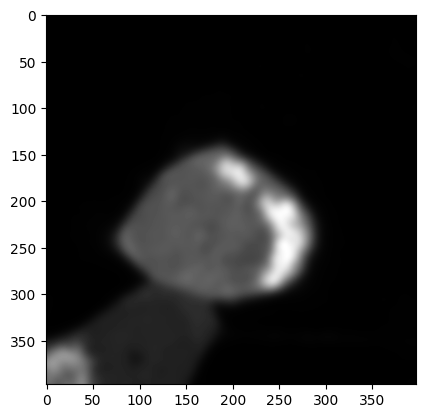

Green Channel


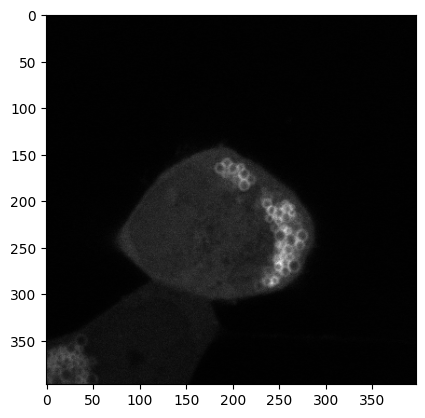

Labeled Cells


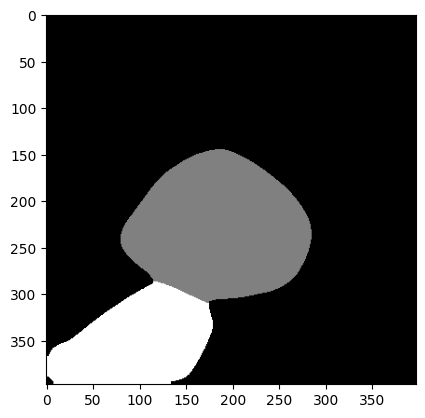

Inclusion Image


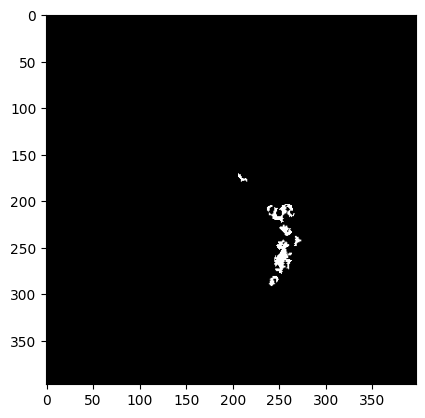

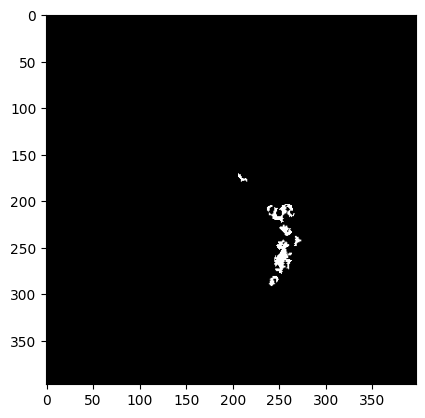

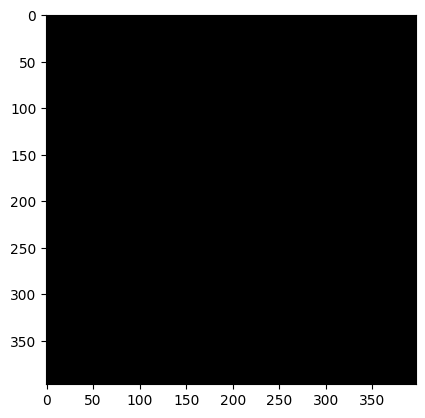

12125_TMRM_YFP/1K_WT_newnewsettings\1K_dox_OA_03.czi
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


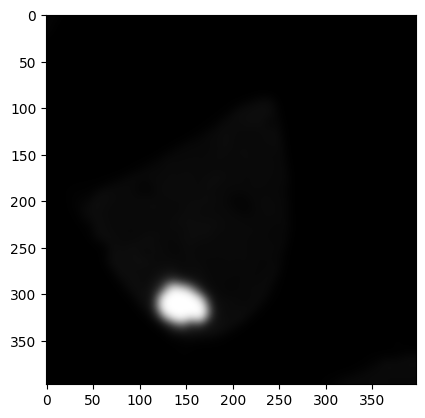

Green Channel


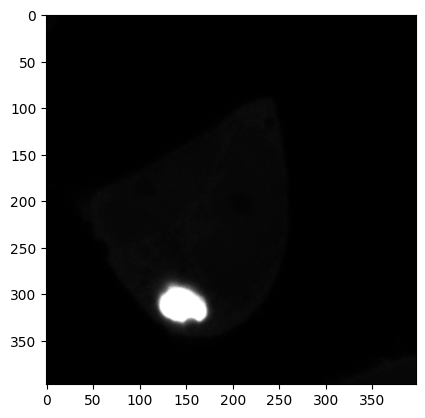

Labeled Cells


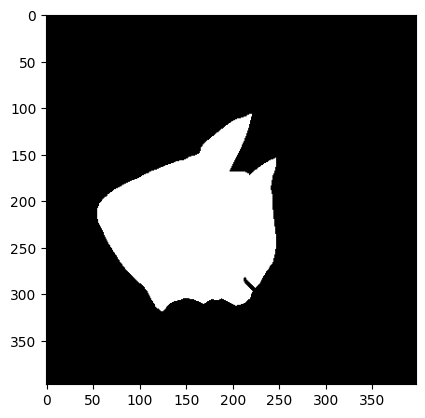

Inclusion Image


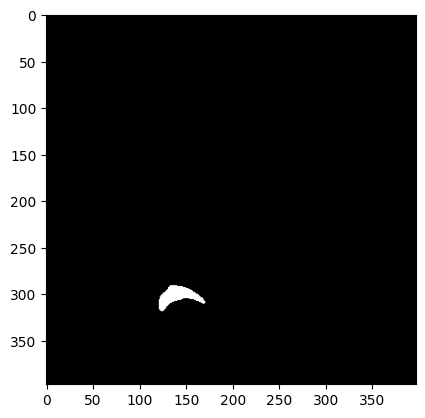

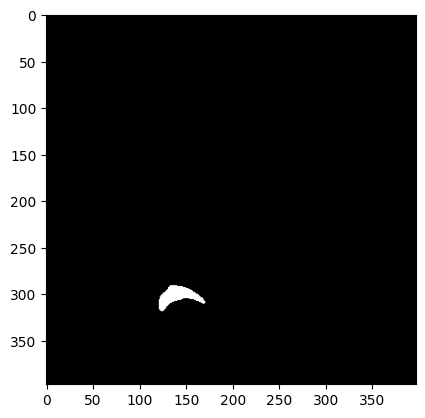

12125_TMRM_YFP/1K_WT_newnewsettings\1K_dox_OA_04.czi
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


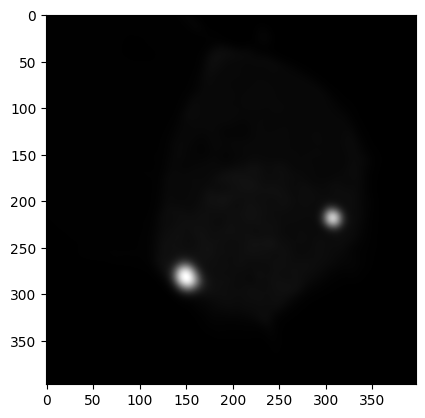

Green Channel


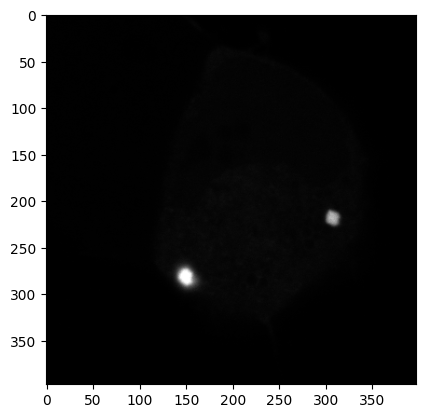

Labeled Cells


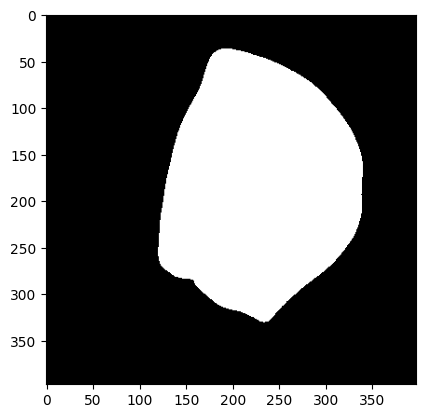

Inclusion Image


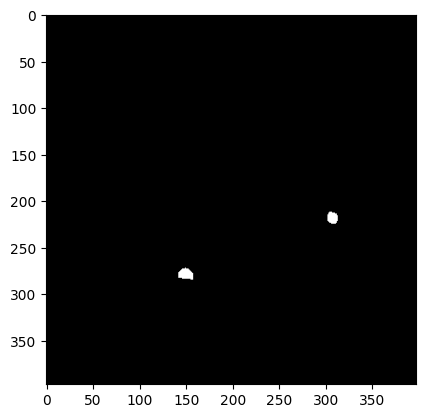

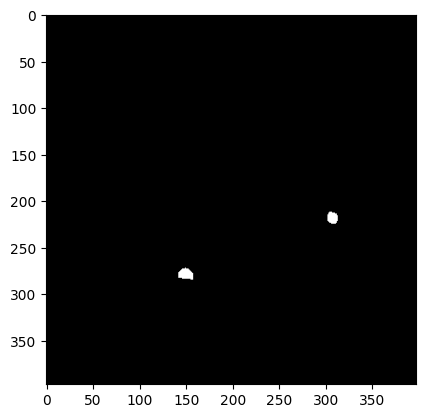

12125_TMRM_YFP/1K_WT_newnewsettings\1K_dox_OA_05.czi
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


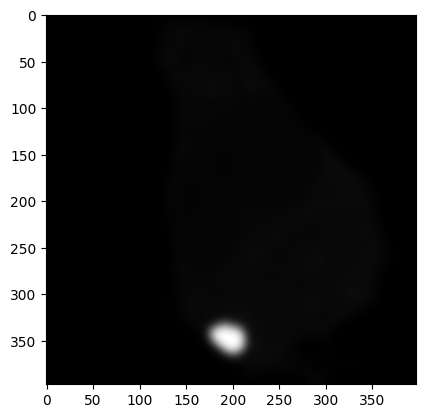

Green Channel


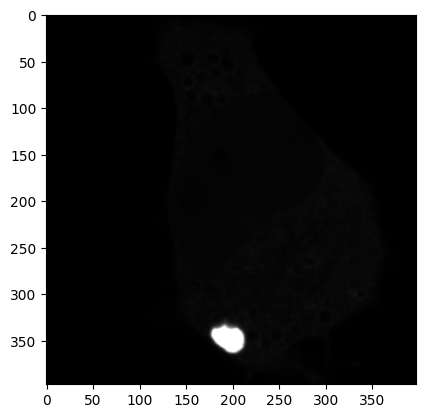

Labeled Cells


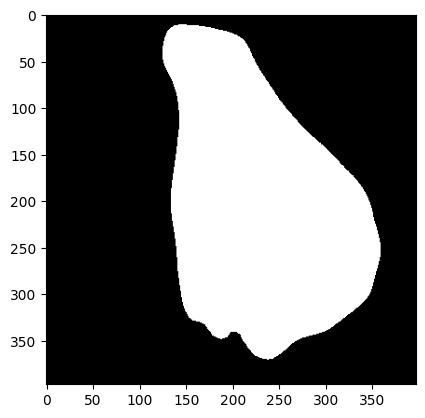

Inclusion Image


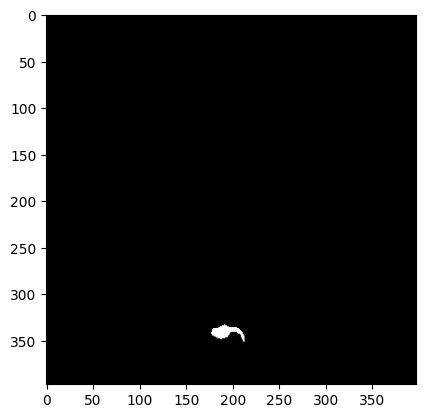

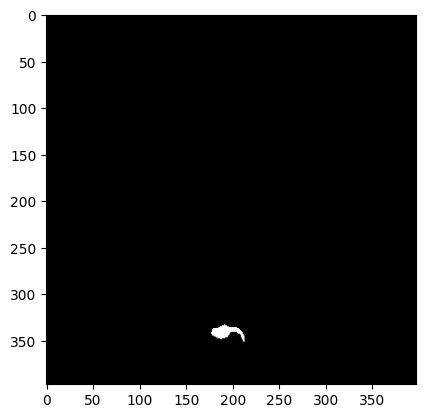

12125_TMRM_YFP/1K_WT_newnewsettings\1K_dox_OA_06.czi
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


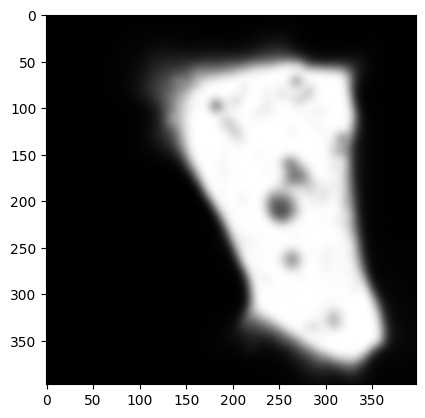

Green Channel


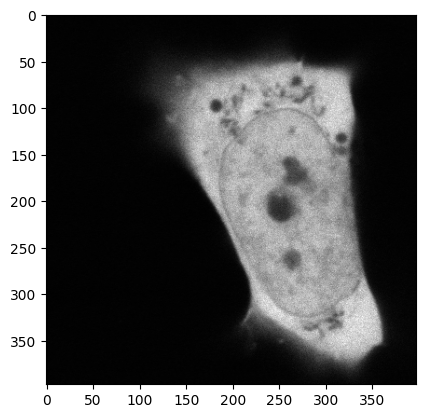

Labeled Cells


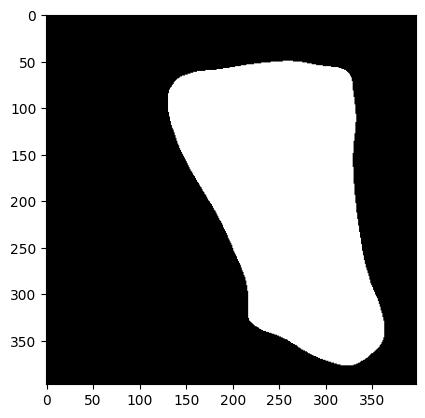

Inclusion Image


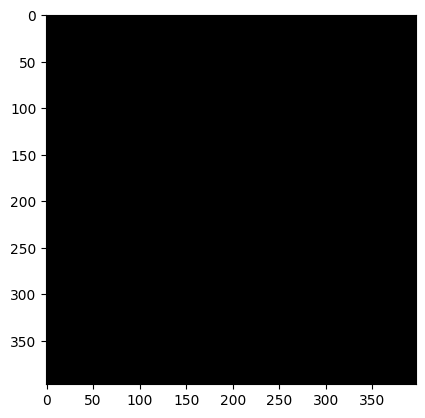

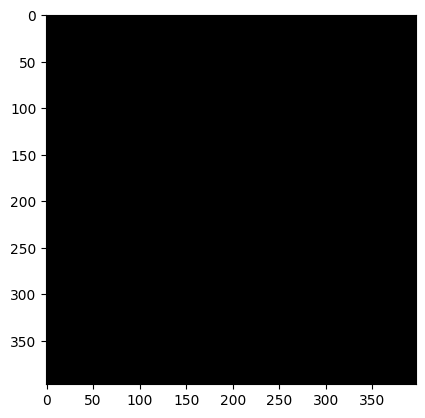

12125_TMRM_YFP/1K_WT_newnewsettings\WT_dox_noOA_01.czi
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


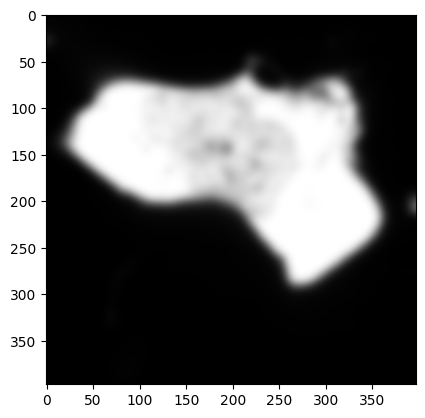

Green Channel


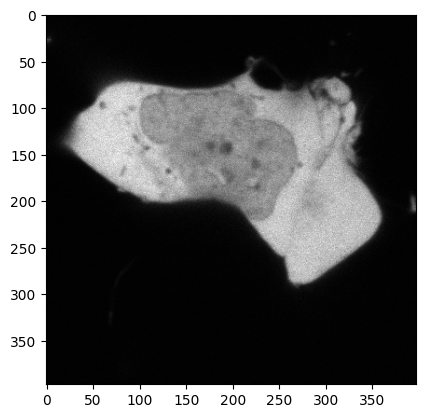

Labeled Cells


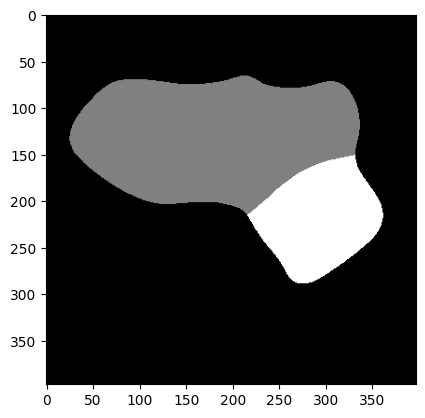

Inclusion Image


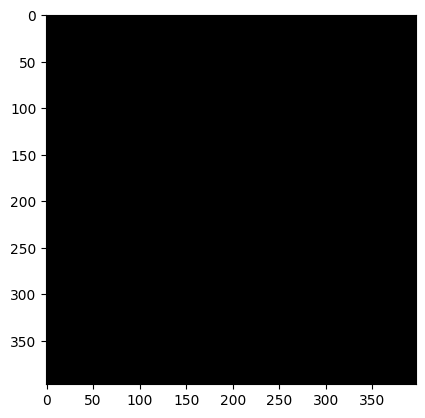

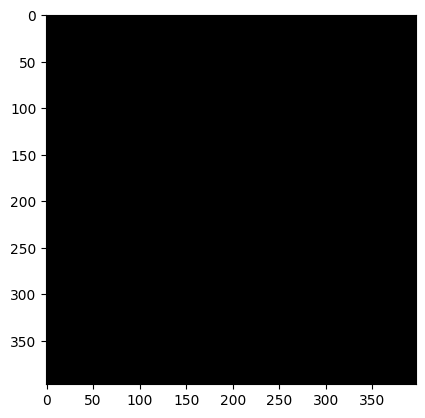

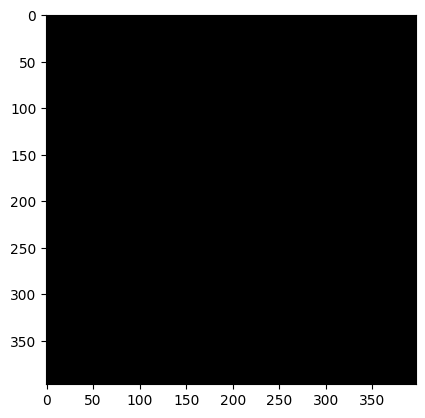

12125_TMRM_YFP/1K_WT_newnewsettings\WT_dox_noOA_02.czi
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


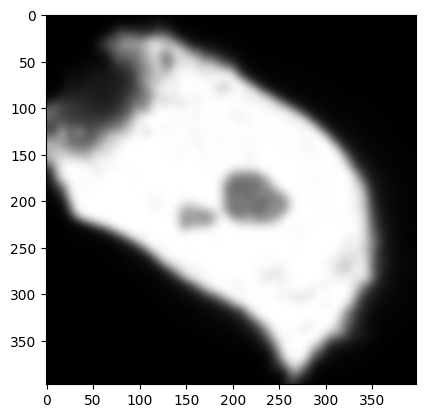

No cells found in 12125_TMRM_YFP/1K_WT_newnewsettings\WT_dox_noOA_03.czi. Skipping.
12125_TMRM_YFP/1K_WT_newnewsettings\WT_dox_noOA_03.czi
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


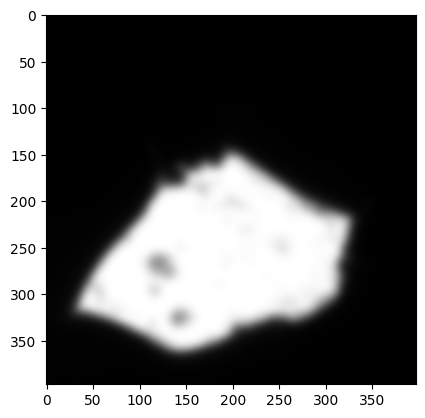

Green Channel


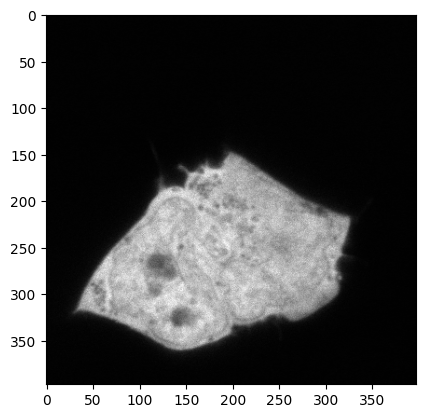

Labeled Cells


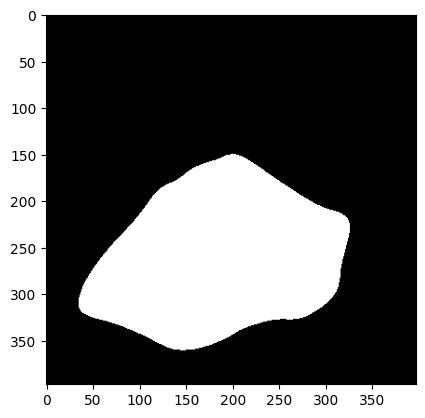

Inclusion Image


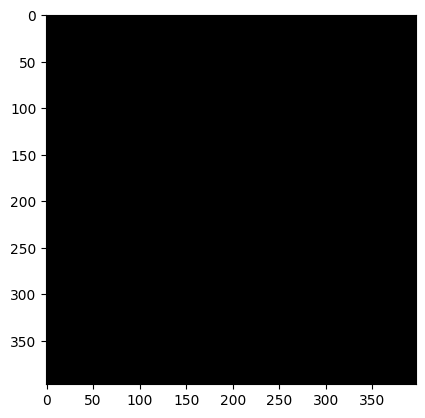

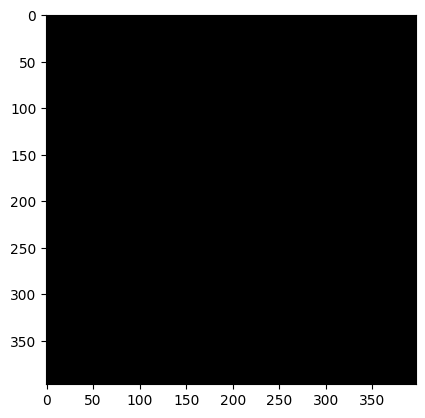

12125_TMRM_YFP/1K_WT_newnewsettings\WT_dox_noOA_04.czi
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


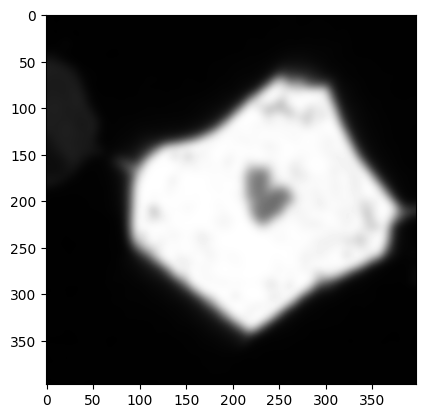

Green Channel


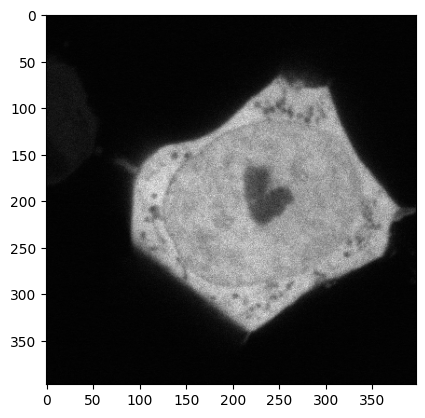

Labeled Cells


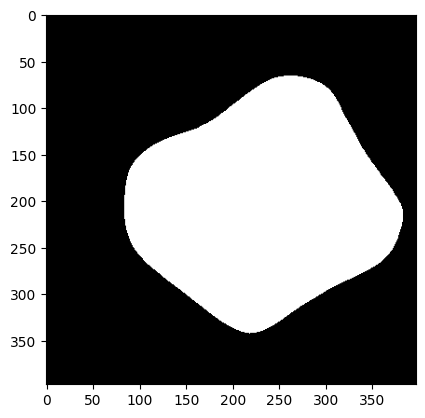

Inclusion Image


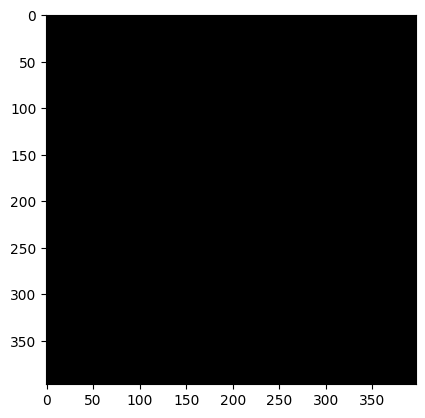

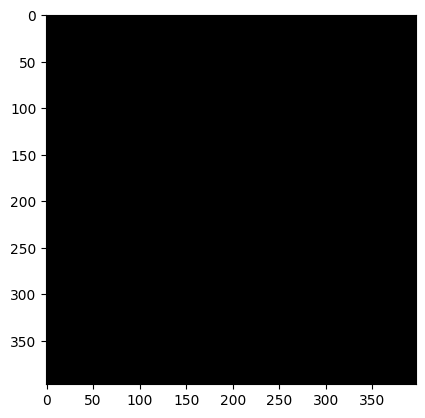

12125_TMRM_YFP/1K_WT_newnewsettings\WT_dox_noOA_05.czi
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


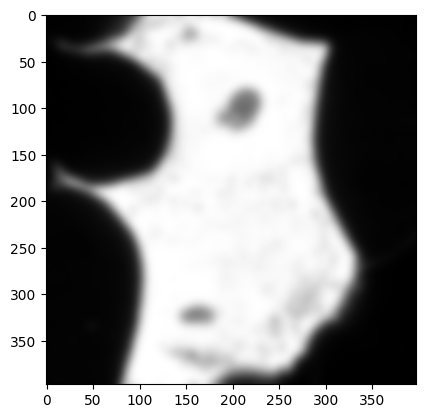

Green Channel


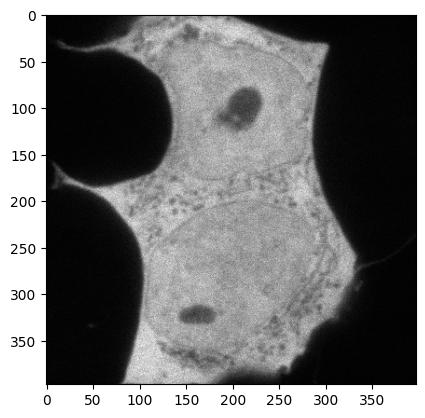

Labeled Cells


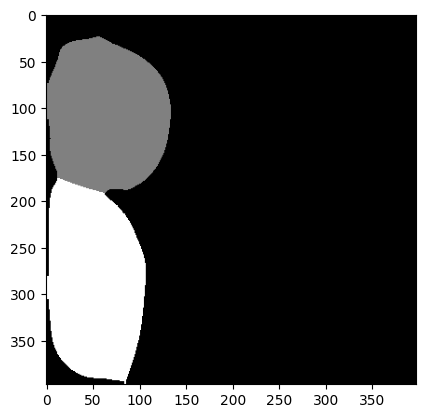

Inclusion Image


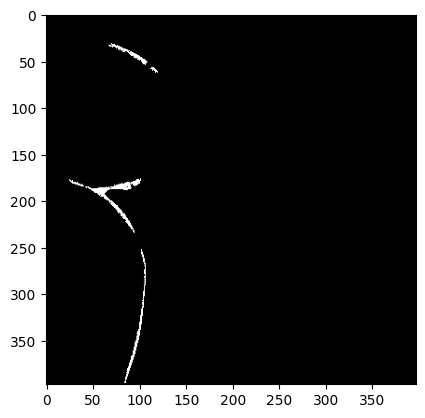

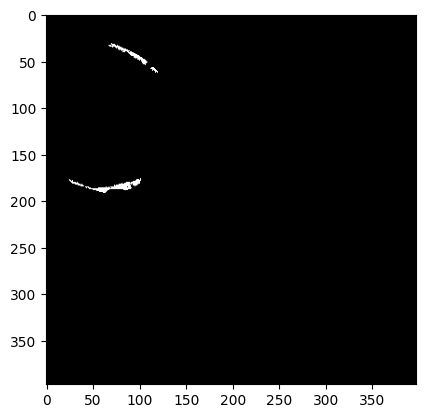

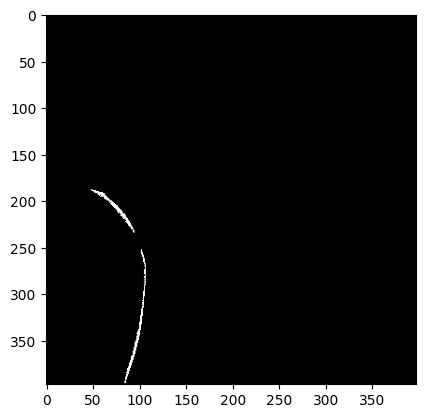

12125_TMRM_YFP/1K_WT_newnewsettings\WT_dox_noOA_06.czi
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


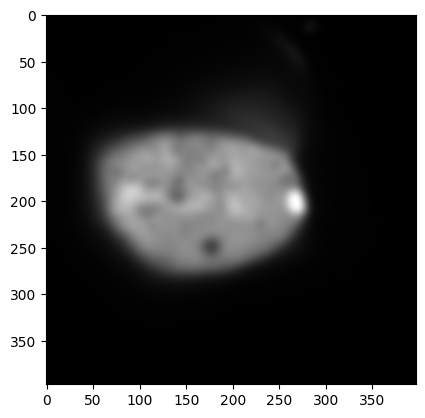

Green Channel


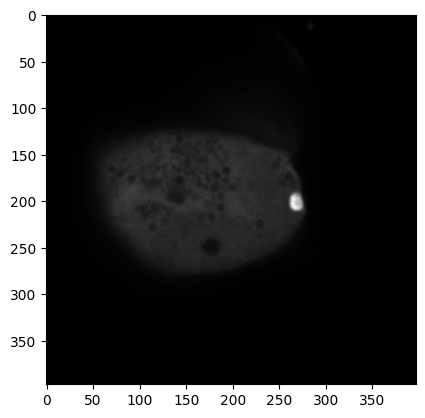

Labeled Cells


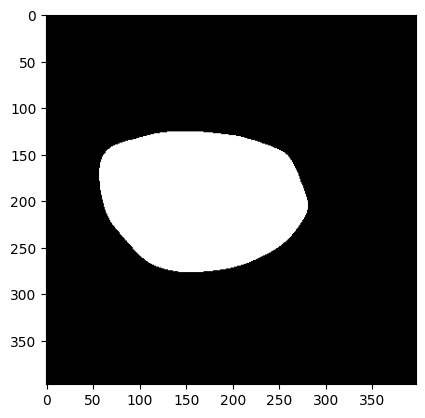

Inclusion Image


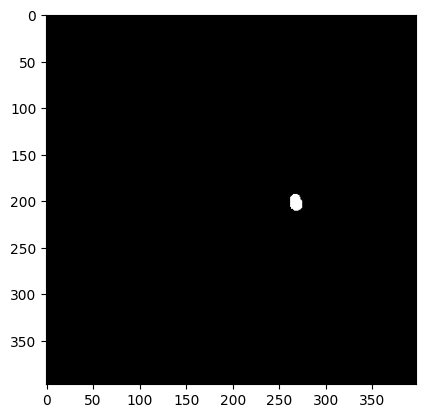

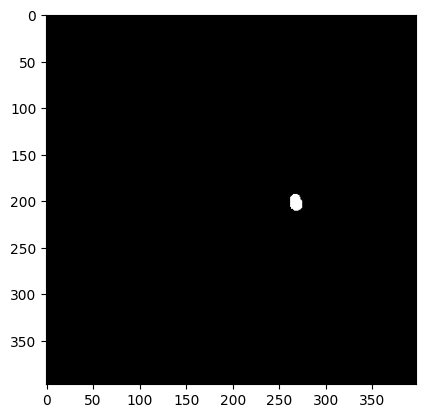

12125_TMRM_YFP/1K_WT_newnewsettings\WT_dox_OA_01.czi
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


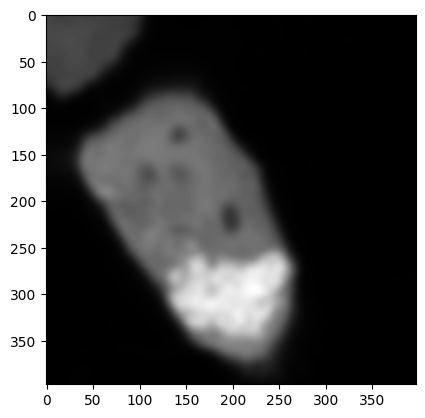

Green Channel


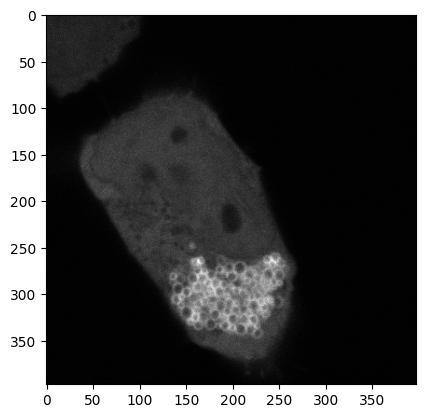

Labeled Cells


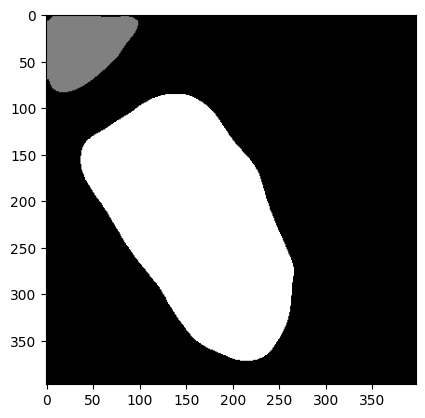

Inclusion Image


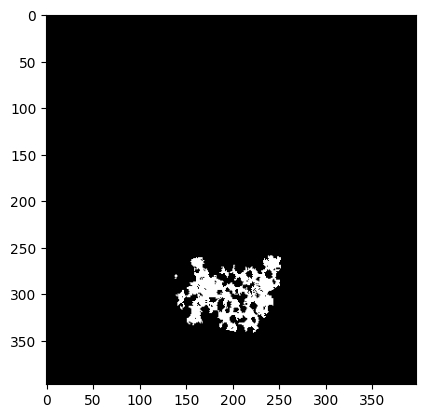

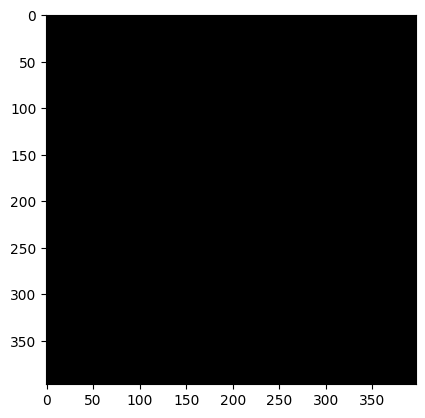

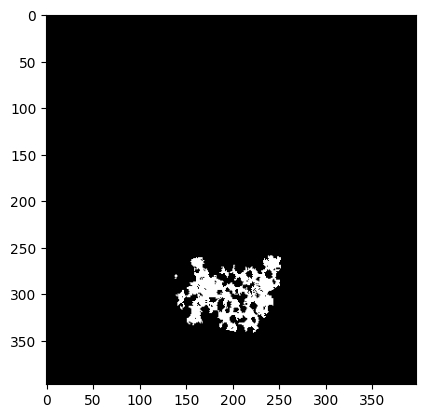

12125_TMRM_YFP/1K_WT_newnewsettings\WT_dox_OA_02.czi
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


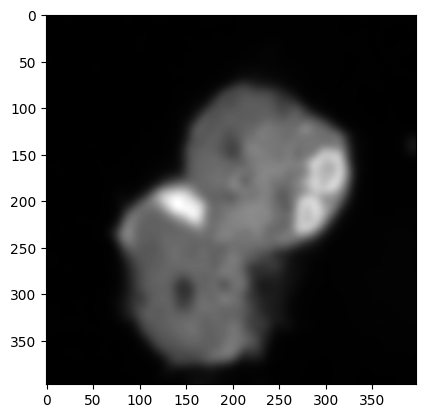

Green Channel


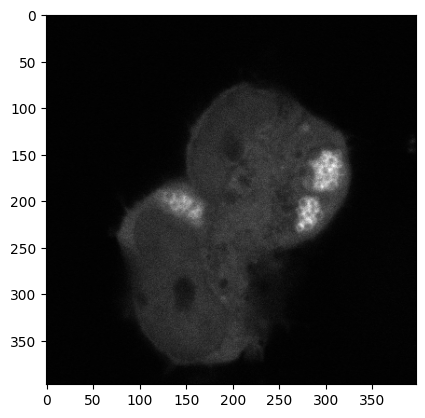

Labeled Cells


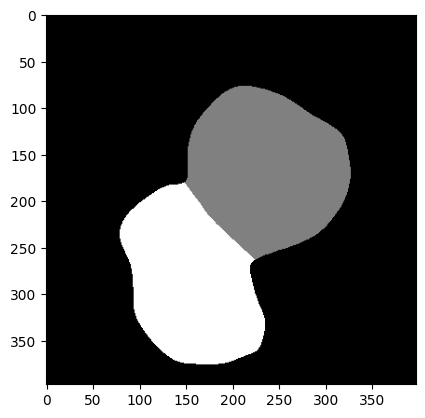

Inclusion Image


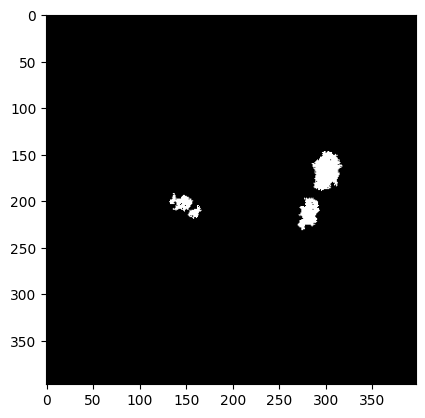

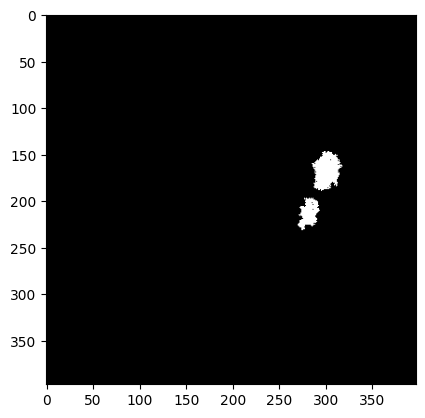

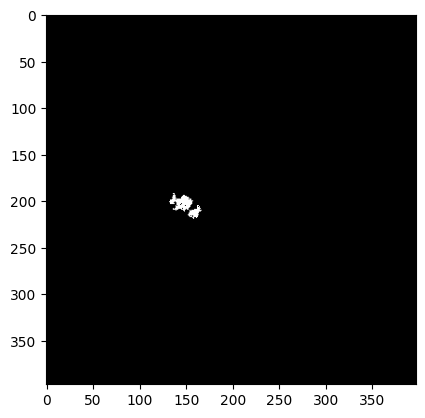

12125_TMRM_YFP/1K_WT_newnewsettings\WT_dox_OA_03.czi
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


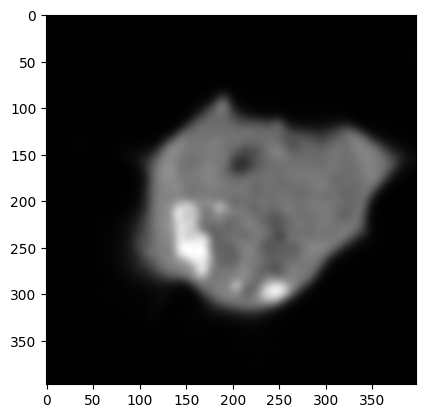

Green Channel


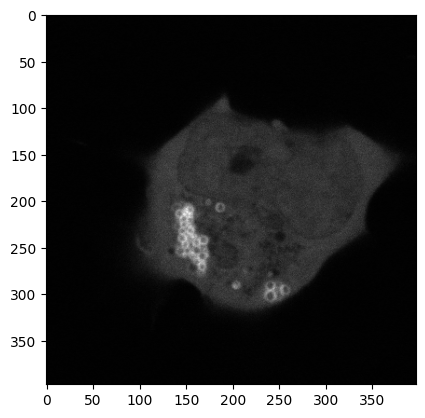

Labeled Cells


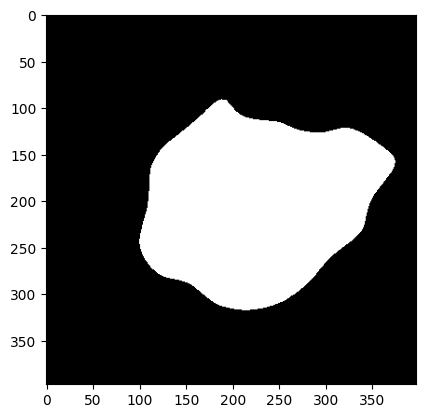

Inclusion Image


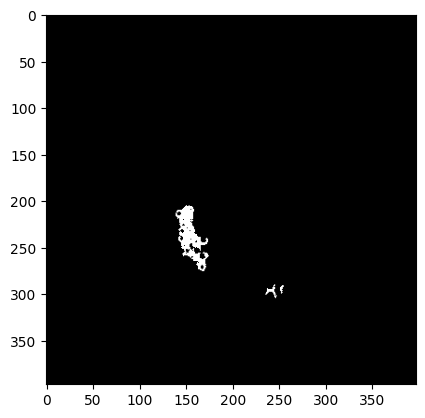

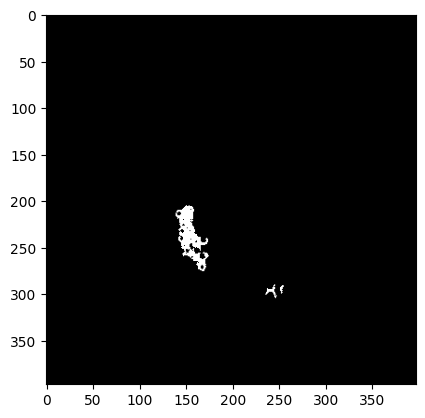

12125_TMRM_YFP/1K_WT_newnewsettings\WT_dox_OA_04.czi
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


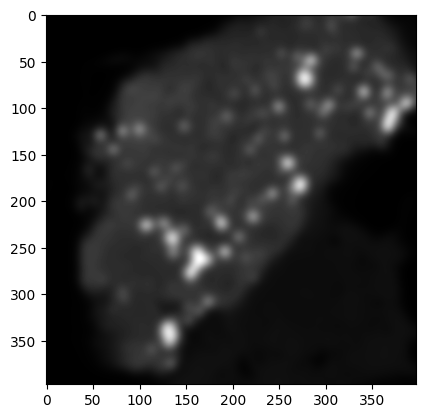

Green Channel


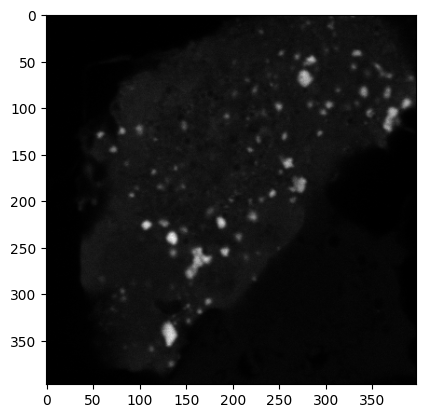

Labeled Cells


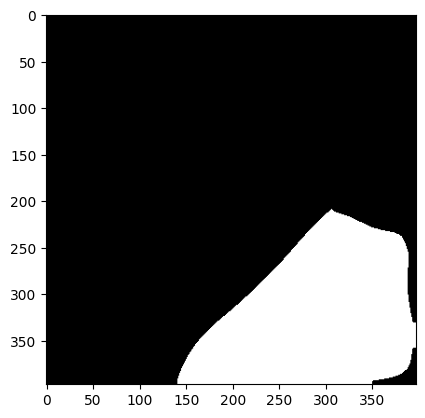

Inclusion Image


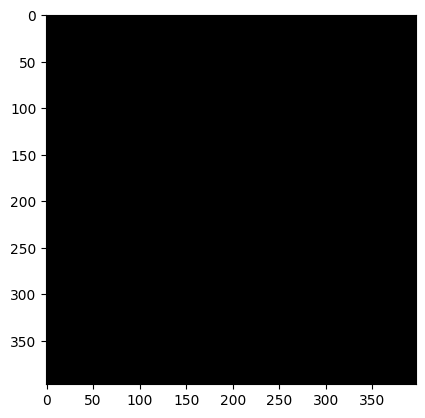

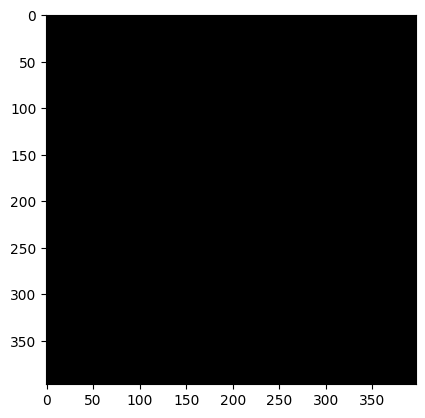

12125_TMRM_YFP/1K_WT_newnewsettings\WT_dox_OA_05.czi
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


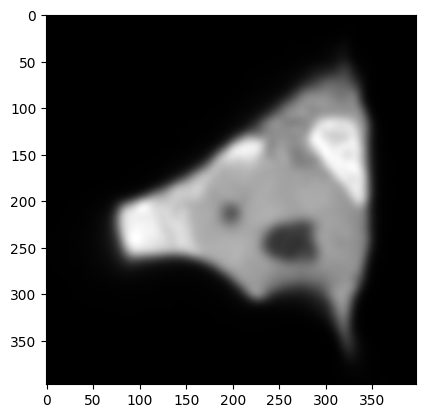

Green Channel


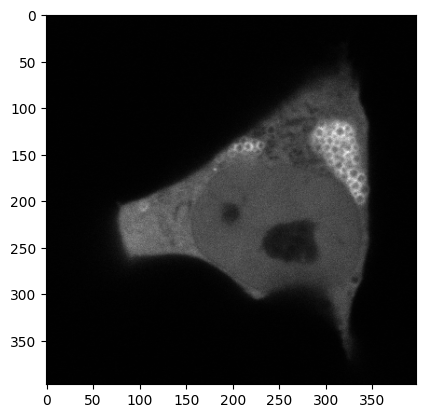

Labeled Cells


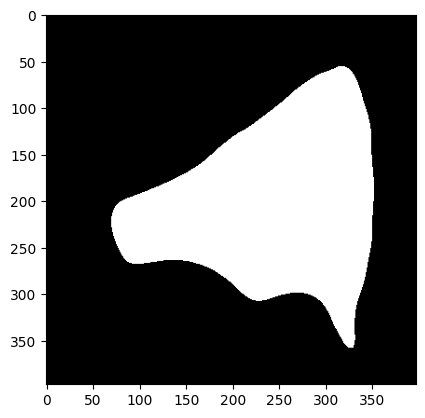

Inclusion Image


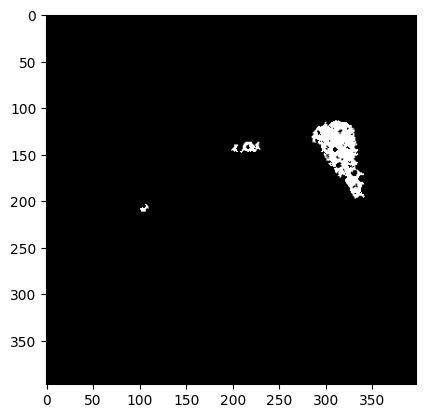

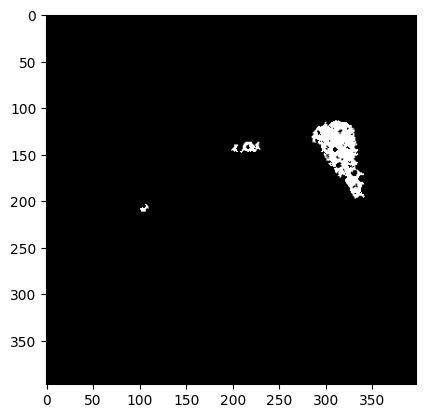

12125_TMRM_YFP/1K_WT_newnewsettings\WT_dox_OA_06.czi
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


PermissionError: [Errno 13] Permission denied: '12125_TMRM_YFP/1K_WT_newnewsettings_analysis_by_image.xlsx'

In [6]:
folder =  '12125_TMRM_YFP/1K_WT_newnewsettings'
analyze_all_images(folder,verbose=True)
# analyze_main_folder('./',True)
